In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')

import cv2
import torch
import numpy as np
from PIL import Image
from transformers import T5EncoderModel, T5Tokenizer
from diffusers import CogVideoXDDIMScheduler, CogVideoXDPMScheduler, AutoencoderKLCogVideoX
from diffusers.utils import load_video, export_to_video
from denku import show_images, add_mask_on_image
from controlnet_aux import CannyDetector, HEDdetector

from controlnet_img2vid_pipeline import CogVideoXImageToVideoControlnetPipeline
from cogvideo_transformer import CustomCogVideoXTransformer3DModel
from cogvideo_controlnet import CogVideoXControlnet

%load_ext autoreload
%autoreload 2

/home/denk/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/denk/.local/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [2]:
def read_video(video_path, start_index=0, frames_count=49, stride=1):
    video_reader = VideoReader(video_path)
    end_index = min(start_index + frames_count * stride, len(video_reader)) - 1
    batch_index = np.linspace(start_index, end_index, frames_count, dtype=int)
    numpy_video = video_reader.get_batch(batch_index).asnumpy()
    return numpy_video

In [3]:
pretrained_model_name_or_path = "THUDM/CogVideoX-5b-I2V"

tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer"
)

text_encoder = T5EncoderModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)

transformer = CustomCogVideoXTransformer3DModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="transformer"
)

vae = AutoencoderKLCogVideoX.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)

scheduler = CogVideoXDDIMScheduler.from_pretrained(
    pretrained_model_name_or_path, subfolder="scheduler"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
controlnet = CogVideoXControlnet.from_pretrained('TheDenk/cogvideox-5b-controlnet-hed-v1')

In [5]:
pipe = CogVideoXImageToVideoControlnetPipeline(
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    transformer=transformer,
    vae=vae,
    controlnet=controlnet,
    scheduler=scheduler,
)
pipe = pipe.to(dtype=torch.float16, device='cuda')

# pipe.enable_model_cpu_offload()
# pipe.enable_sequential_cpu_offload()

In [6]:
# controlnet_processor = CannyDetector()
controlnet_processor = HEDdetector.from_pretrained("lllyasviel/Annotators")

/home/denk/.local/lib/python3.10/site-packages/controlnet_aux/hed/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netNetwork.load_state_dict(torch.load(model_p

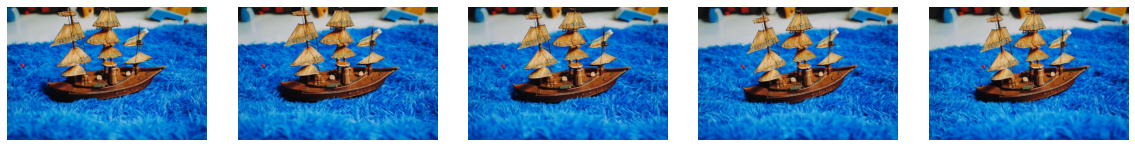

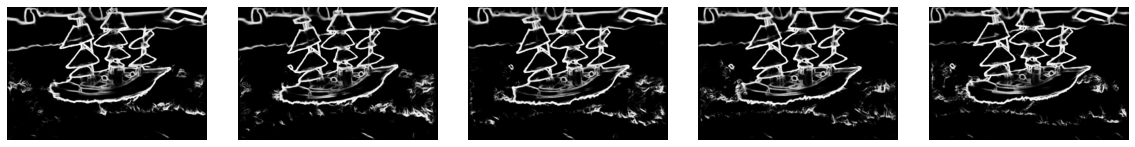

In [7]:
num_frames = 49
video_path = '../resources/ship.mp4'
video_frames = load_video(video_path)[:num_frames]
controlnet_frames = [controlnet_processor(x) for x in video_frames][::-1]

show_images(video_frames[::10], figsize=(16, 8))
show_images(controlnet_frames[::10], figsize=(16, 8))

In [8]:
output = pipe(
    image=video_frames[-1],
    controlnet_frames=controlnet_frames,
    prompt="A detailed wooden toy ship with intricately carved masts and sails is seen gliding smoothly over a plush, blue carpet that mimics the waves of the sea. The ship's hull is painted a rich brown, with tiny windows. The carpet, soft and textured, provides a perfect backdrop, resembling an oceanic expanse. Surrounding the ship are various other toys and children's items, hinting at a playful environment. The scene captures the innocence and imagination of childhood, with the toy ship's journey symbolizing endless adventures in a whimsical, indoor setting.",
    height=480,
    width=720,
    num_frames=49,
    guidance_scale=6,
    num_inference_steps=50,
    generator=torch.Generator(device="cuda").manual_seed(42),
    controlnet_weights=0.8,
    controlnet_guidance_start=0.0,
    controlnet_guidance_end=0.8,
)

  0%|          | 0/50 [00:00<?, ?it/s]

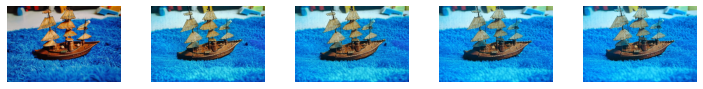

In [9]:
show_images(output.frames[0][::10], figsize=(10, 10))

In [10]:
export_to_video(output.frames[0], 'contolnet_out.mp4', fps=8)

'contolnet_out.mp4'